# Hydrological Analysis Tutorial
In diesem Tutorial werden wir auf Grundlage von Niederschlags- und Pegelabflusszeitreihen schrittweise eine Niederschlagsabflussvorhersage mittel Machine Learning Methoden durchführen. Wir beginnen zunächst mit einem einfachen "Baseline" Ansatz, der uns als Referenz zur Beurteilung der Performance komplexerer Modelle dienen soll. Als Datensätze verwenden wir die Zeitreihen einiger ausgewählter Einzugsgebiete des CAMELS Datsets, der meteorologische Daten und Parameter für verschiedene Flusseinzugsgebiete der USA enthält:  
* _A. Newman; K. Sampson; M. P. Clark; A. Bock; R. J. Viger; D. Blodgett, 2014. A large-sample watershed-scale hydrometeorological dataset for the contiguous USA. Boulder, CO: UCAR/NCAR. https://dx.doi.org/10.5065/D6MW2F4D_
* _A. J. Newman, M. P. Clark, K. Sampson, A. Wood, L. E. Hay, A. Bock, R. J. Viger, D. Blodgett, L. Brekke, J. R. Arnold, T. Hopson, and Q. Duan: Development of a large-sample watershed-scale hydrometeorological dataset for the contiguous USA: dataset characteristics and assessment of regional variability in hydrologic model performance. Hydrol. Earth Syst. Sci., 19, 209-223, doi:10.5194/hess-19-209-2015, 2015_

## Setup
Als initiales Setup werden zunächst die benötigten Bibliotheken sowie eigene Packages geladen, die einige Hilfsfunktionen beinhalten, um z.B. Datensätze zu laden oder unsere späteren Modelle zu evaulieren. Außerdem werden die Pfade zu den relevanten Datensätzen gesetzt. Wir wollen uns zunächst auf ein einzelnes Einzugsgebiet konzentrieren. Bei Bedarf, kann hier auch ein alternatives Einzugsgebiet des CAMELS Datset gewählt werden. Hierzu sind die Pfade entsprechend anzupassen.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Custom libs
from scripts import dataio as dataio

basin_id = "11522500" # ID des Einzugsgebiets kann bei Bedarf angepasst werden

forcings_path = "./data/" + basin_id + "_lump_cida_forcing_leap.txt" # Pfad zur Datei mit den meteoroloigschen Zeitreihendaten des Einzugsgebiets
streamflow_path = "./data/" + basin_id + "_streamflow_qc.txt" # Pfad zur Datei mit der Abflusszeitreihe des Einzugsgebiets

## Data analysis
Bevor wir damit beginnen unsere Aufgabenstellung zu formalisieren und ein erstes Modell aufzustellen, schauen wir zunächst den verwedenten CAMELS Datensatz sowie dessen Parameter an. Hierzu laden wir die meteorologischen Parameter sowie die Abflussdaten aus den beiden Textdateien mit der Hilfsfunktion `load_forcings` als `DataFrame` und geben die ersten Zeilen aus. Zunächst der Datensatz mit den meteorologischen Zeitreihen:

In [3]:
df_forcings = dataio.load_forcings(forcings_path)
df_forcings.head()

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
date,,,,,,,
1980-01-01,32720.28,7.30,142.87,0.0,6.21,-2.91,508.16
1980-01-02,32801.48,0.00,185.77,0.0,1.25,-7.76,361.16
1980-01-03,32831.98,0.00,92.57,0.0,-0.28,-4.38,450.41
1980-01-04,32831.98,0.00,218.07,0.0,11.44,-0.70,584.35
1980-01-05,32831.98,12.14,115.53,0.0,10.24,2.90,755.63


Wir erkennen, dass der Datensatz 7 verschiedene Parameter enthält:
* `dayl(s)`: Tageslänge (daylength)
* `prcp(mm/day)`: Niederschlagssumme (precipitation)
* `srad(W/m2)`: Kurzwellenstrahlung (shortwave radiation)
* `swe(mm)`: Schneewasseräquivalent (snow water equivalent)
* `tmax(C)`: maximale Tagestemperatur
* `tmin(C)`: minimale Tagestemperatur
* `vp(Pa)`: Dampfdruck (vapor pressure)

Der DataFrame ist außerdem mit einem Zeitstempel indiziert. Die zeitliche Auflösung entspricht einem Tag, beginnend ab dem 01.01.1980. 

Als nächstes schauen wir uns den Datensatz mit den Abflusszeitreihen an:

In [4]:
df_streamflow = dataio.load_streamflow(streamflow_path)
df_streamflow.head()

,gauge_id,streamflow,qc_flag
date,,,
1980-01-01,11522500,3100.0,A
1980-01-02,11522500,2800.0,A
1980-01-03,11522500,2560.0,A
1980-01-04,11522500,2320.0,A
1980-01-05,11522500,2940.0,A


Auch hier ist der DataFrame mit einem Zeitstempel indiziert. Hierbei handelt es sich ebenfalls um Tageswerte. Desweiteren weist der Datensatz die folgenden 3 Parameter auf:
* `gauge_id`: ID des Pegels (entspricht der ID des Eizungsgebiets)
* `streamflow`: täglicher durchschnittlicher Durchfluss in Kubikfuß pro Sekunde (ft$^3$/s)
* `qc_flag`: Qualitätsmerkmal eines Durchflusswerts mit folgender Bedeutung: A -> tatsächlicher Wert, A:e -> geschätzter Wert M -> fehlender Wert

Mit der zeitlichen Indizierung der Datensätze, lassen sich die zeitlichen Verläufe der Messwerte nun auf einfach Weise grafisch darstellen.

<AxesSubplot:title={'center':'Durchfluss für das Einzugsgebiet 11522500'}, xlabel='Datum', ylabel='Durchfluss [ft$^3$/s]'>

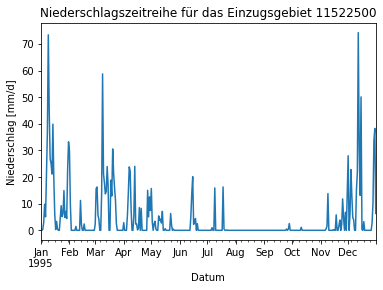

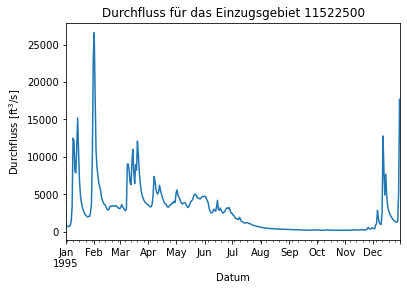

In [5]:
df_forcings["1995-01":"1995-12"].plot(y="prcp(mm/day)", title="Niederschlagszeitreihe für das Einzugsgebiet " + basin_id,
                                      legend=False, xlabel="Datum", ylabel="Niederschlag [mm/d]")
df_streamflow["1995-01":"1995-12"].plot(y="streamflow", title="Durchfluss für das Einzugsgebiet " + basin_id,
                                       legend=False, xlabel="Datum", ylabel="Durchfluss [ft$^3$/s]")

### Aufgaben
1) Welchen Zeitraum decken die beiden Datensätze ab? Verwenden Sie für die Bestimmung der Extrema die Python Library [pandas ](https://pandas.pydata.org/docs/index.html). Welche Kennzahlen der deskriptiven Statistik lassen sich noch bestimmen?
2) Stellen Sie den Verlauf der maximalen Tagestemperatur über einen Zeitraum vom 01.04.2005 bis 15.04.2005 grafisch in einem Liniendiagramm dar. Nutzen Sie hierfür [Matplotlib](https://matplotlib.org/).
3) Rechnen Sie den Durchfluss von ft$^3$/s in m$^3$/s um und ersetzen Sie die Werte der Spalte `streamflow` durch die umgerechneten Werte. (Hinweis: Der Umrechnungsfaktor von m$^3$ nach ft$^3$ beträgt ~35.315. D.h. $ft^3$ $\approx$ $m^3*35.315$)

### Aufgabe 1

In [6]:
print("Niederschlag\nStartdatum: {0}, Enddatum {1}\nDurchfluss\nStartdatum: {2}, Enddatum {3}".
      format(df_forcings.index.min().strftime("%Y-%m-%d"), df_forcings.index.max().strftime("%Y-%m-%d"),
             df_forcings.index.min().strftime("%Y-%m-%d"), df_forcings.index.max().strftime("%Y-%m-%d")))

Niederschlag
Startdatum: 1980-01-01, Enddatum 2014-12-31
Durchfluss
Startdatum: 1980-01-01, Enddatum 2014-12-31


In [7]:
df_forcings.describe()

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
count,12784.000000,12784.000000,12784.000000,12784.0,12784.000000,12784.000000,12784.000000
mean,43192.643773,3.181682,345.831186,0.0,14.956718,0.978404,571.077555
std,7443.592959,7.482104,143.833165,0.0,8.687471,5.451942,213.471982
min,32486.380000,0.000000,30.970000,0.0,-10.130000,-21.960000,116.080000
25%,35942.370000,0.000000,220.792500,0.0,7.600000,-2.750000,421.570000
50%,43199.970000,0.000000,358.060000,0.0,14.360000,0.830000,544.610000
75%,50457.630000,2.412500,474.042500,0.0,22.530000,4.780000,686.737500
max,53913.610000,83.780000,653.730000,0.0,37.170000,20.440000,1750.350000


### Aufgabe 2
#### Object oriented style

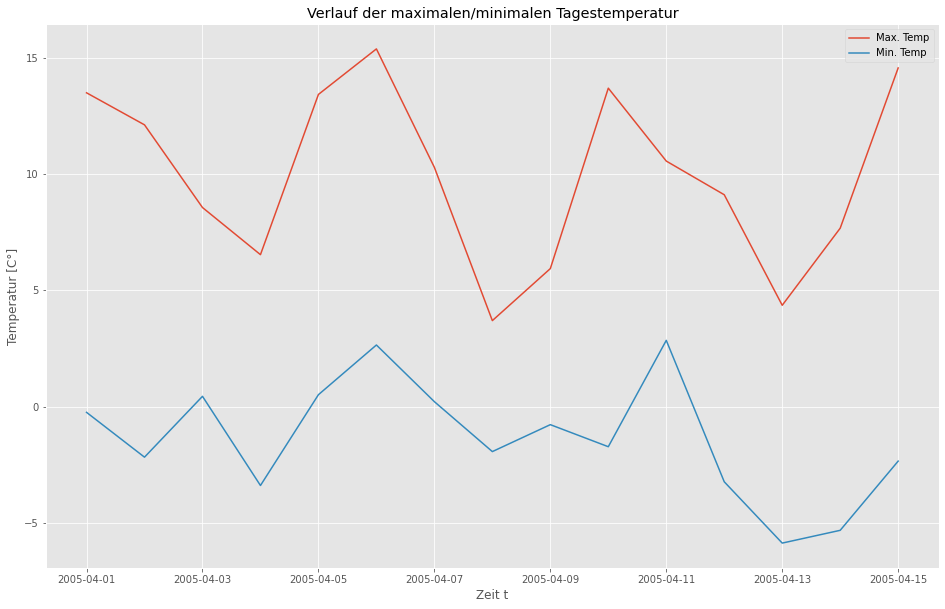

In [8]:
plt.style.use(['ggplot'])

# Object oriented style
subset = df_forcings["2005-04-01":"2005-04-15"]
fig, ax = plt.subplots(figsize=(16,10))  # Create a figure and an axes.
ax.plot(subset.index, subset["tmax(C)"], label='Max. Temp')
ax.plot(subset.index, subset["tmin(C)"], label='Min. Temp')
ax.set_xlabel('Zeit t')  # Add an x-label to the axes.
ax.set_ylabel('Temperatur [C°]')  # Add a y-label to the axes.
ax.set_title("Verlauf der maximalen/minimalen Tagestemperatur")  # Add a title to the axes.
ax.legend()  # Add a legend.

#### Pyplot style

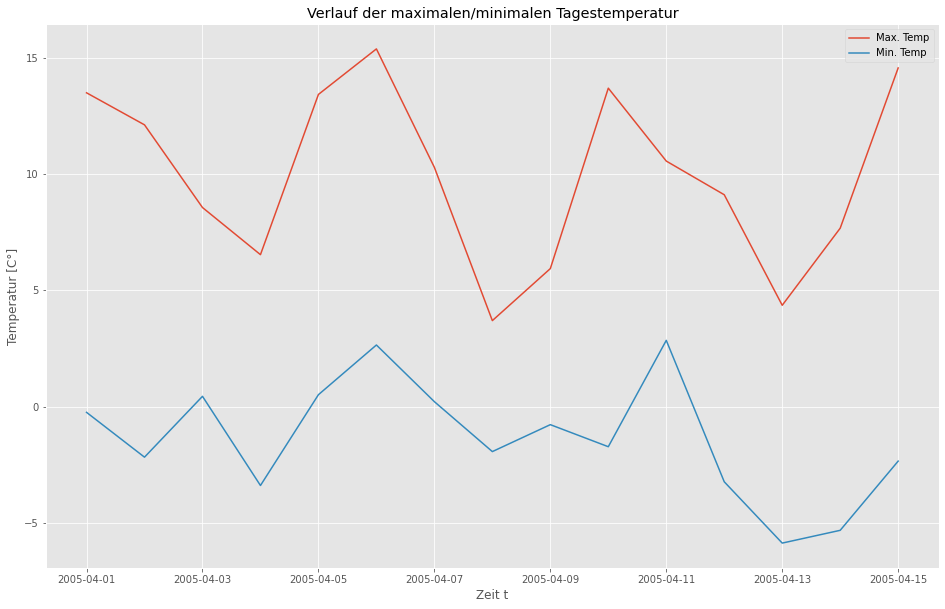

In [12]:
# TODO Aufgabe 3
# Pyplot style
plt.figure(figsize=(16, 10))
plt.plot(subset.index, subset["tmax(C)"], label='Max. Temp')
plt.plot(subset.index, subset["tmin(C)"], label='Min. Temp')
plt.xlabel('Zeit t')
plt.ylabel('Temperatur [C°]')
plt.title("Verlauf der maximalen/minimalen Tagestemperatur")
plt.legend()

### Aufgabe 3

In [14]:
# TODO Aufgabe 3
factor = 35.315
df_streamflow["converted_streamflow"] = df_streamflow["streamflow"] / factor
df_streamflow.head()

,gauge_id,streamflow,qc_flag,converted_streamflow
date,,,,
1980-01-01,11522500,3100.0,A,87.781396
1980-01-02,11522500,2800.0,A,79.286422
1980-01-03,11522500,2560.0,A,72.490443
1980-01-04,11522500,2320.0,A,65.694464
1980-01-05,11522500,2940.0,A,83.250743
